## Image contours with SAM (Segment Anything Masks)

Just experiments with Meta's https://github.com/facebookresearch/segment-anything

/home/jd/segment-anything/notebooks/images/dog.jpg ; exist: True
/home/jd/segment-anything/models/sam_vit_h_4b8939.pth ; exist: True
PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: True


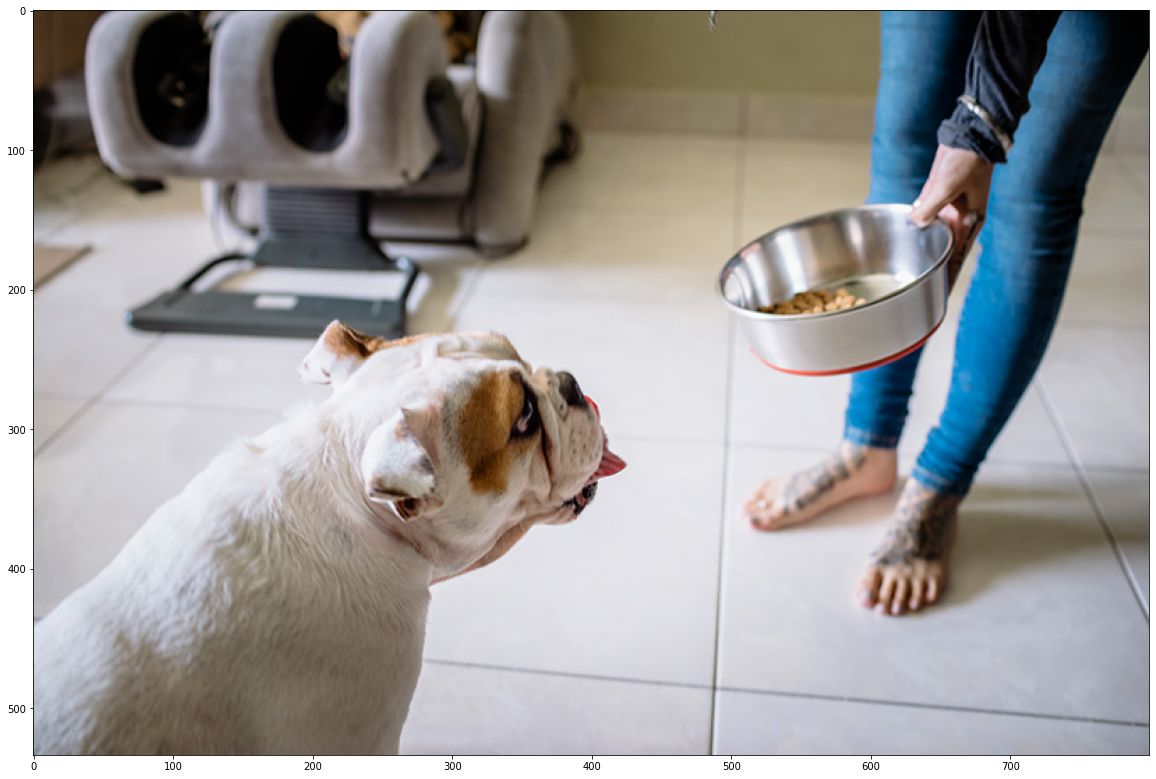

In [1]:
# Setup

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

IMAGE_PATH = "/home/jd/segment-anything/notebooks/images/dog.jpg"
print(IMAGE_PATH, "; exist:", os.path.isfile(IMAGE_PATH))
CHECKPOINT_PATH = "/home/jd/segment-anything/models/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

image_sam = cv2.imread(IMAGE_PATH)
image_sam = cv2.cvtColor(image_sam, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image_sam)
image_copy = image_sam.copy()

In [2]:
# Auto generate masks

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = "/home/jd/segment-anything/models/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
MODEL_TYPE = "vit_h"

device = "cuda"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/jd/segment-anything/models/sam_vit_h_4b8939.pth ; exist: True


In [3]:
# Details on masks
masks = mask_generator.generate(image_sam)
print(len(masks))
print(masks[0].keys())
print(masks[0]['segmentation'].shape)

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
(534, 800)


In [4]:
# Get masks and draw contours around them
def show_contours(masks, image_sam):
    if len(masks) == 0:
        return
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True) # sort masks by largest area
    for mask in sorted_masks:
        mask_seg = mask['segmentation'] # Get segmentation mask
        mask_8bit = np.uint8(mask_seg * 255) # Convertion for contours
        contours = cv2.findContours(mask_8bit,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
        rantup = (np.random.randint(0,256), np.random.randint(0,256), np.random.randint(0,256))
        cv2.drawContours(image_sam,contours,-1,rantup,3)

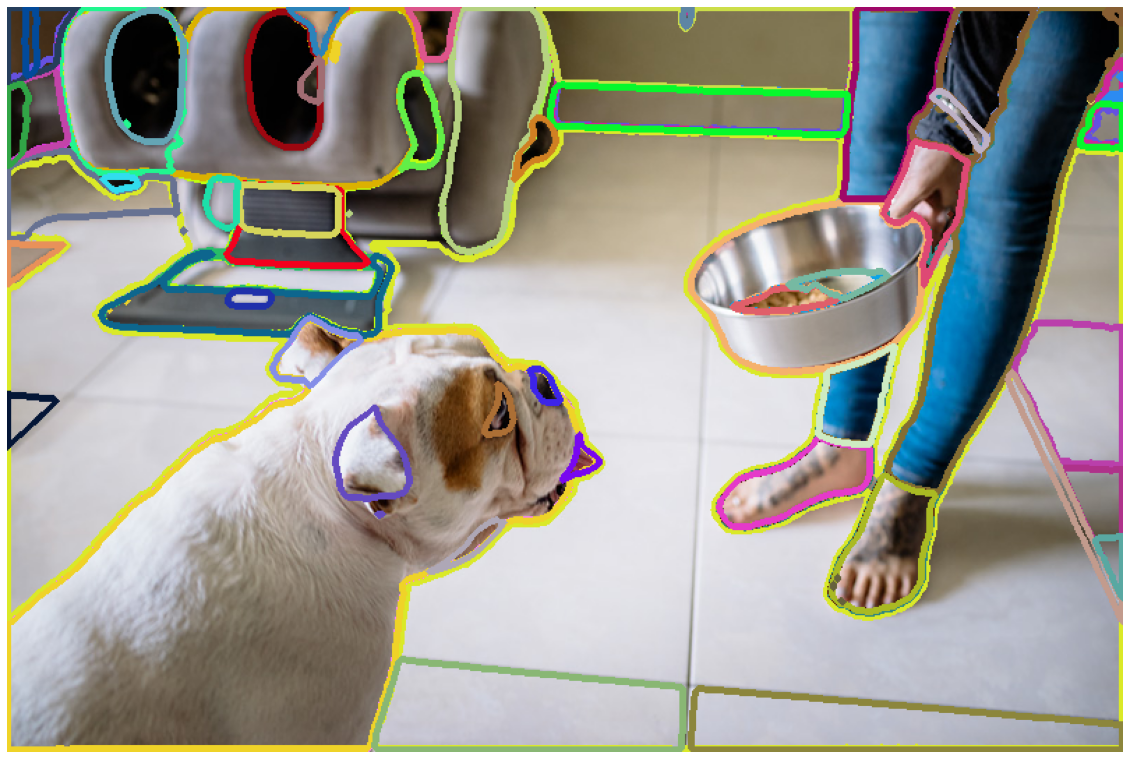

In [5]:
# View masks on the image
plt.figure(figsize=(20,20))
show_contours(masks, image_sam)
plt.imshow(image_sam)
plt.axis('off')
plt.show()
plt.close()

In [6]:
# Get masks and draw segmented areas around them
def show_masks(masks, image_copy):
    if len(masks) == 0:
        return
    #plt.imshow(image_sam)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True) # sort masks by largest area
    img = np.ones((sorted_masks[0]['segmentation'].shape[0], sorted_masks[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for mask in sorted_masks:
        f_m_s = mask['segmentation'] # Get segmentation mask
        random_color = [0.0000001, 0.0000001, 0.0000001]
        #Make color translucent
        color_mask = np.concatenate([np.random.random(3), [0.40]]) #[1.0e-07 1.0e-07 1.0e-07 9.5e-01]
        #Merge back in image
        img[f_m_s] = color_mask
    ax.imshow(img)

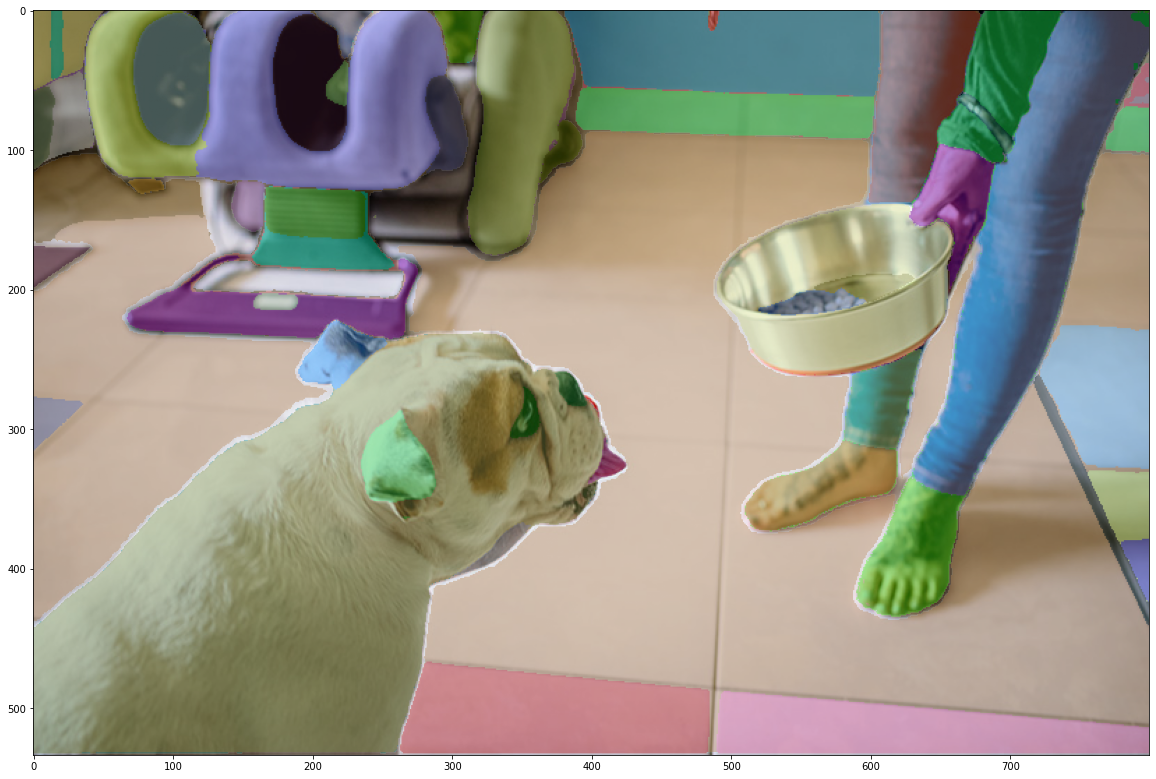

In [7]:
# View masks on the image (Copy)
plt.figure(figsize=(20,20))
plt.imshow(image_copy)
show_masks(masks, image_copy)
plt.axis('on')
plt.show()
plt.close()

In [8]:
# Convert and output jpg
image_sam_out = cv2.cvtColor(image_sam, cv2.COLOR_RGB2BGR)
cv2.imwrite('sam_image_out.jpg', image_sam_out)

True